# Transit fitting pipeline

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from archeopteryx.constants import *
from archeopteryx.utils import *
from archeopteryx.Planet import *
from archeopteryx.LiteCurve import *
import archeopteryx.io as io
import archeopteryx.detrend as detrend
import archeopteryx.noise as noise


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  CSV_FILE, TIME_START, and TIME_END

In [2]:
# select mission and target
MISSION = 'Simulated'            # mission can be 'Kepler' or 'Simulated'
#TARGET  = '20200319164408'       # target (KOI number in format 'Kxxxxx' or SIM_ID)
TARGET  = '20200325111052'       # target (KOI number in format 'Kxxxxx' or SIM_ID)

# set paths
PRIMARY_DIR = '/Users/research/projects/archeopteryx/'
CSV_FILE    = '/Users/research/projects/archeopteryx/Catalogues/simulations_observed.csv'


#MISSION = "Kepler"
#TARGET  = "K00137"
#PRIMARY_DIR = '/Users/research/projects/archeopteryx/'
#CSV_FILE    = '/Users/research/projects/archeopteryx/Catalogues/pure_cks2.csv'


# set time baseline
TIME_START = 0.
TIME_END   = 1600.

In [3]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directory in which to place Figures, & Traces
FIGURE_DIR   = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR    = PRIMARY_DIR + 'Traces/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)

# Read in planet and stellar parameters from Kepler/Gaia

In [4]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)


if MISSION == 'Kepler':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_starname']) == TARGET

    KIC    = np.array(target_dict['id_kic'], dtype='int')[use]
    NPL    = np.array(target_dict['koi_count'], dtype='int')[use]
    RSTAR  = np.array(target_dict['iso_srad'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['iso_smass'], dtype='float')[use]

    PERIODS = np.array(target_dict['koi_period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['koi_time0'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833
    DEPTHS  = np.array(target_dict['koi_depth'], dtype='float')[use]*1e-6          # [ppm] --> []
    DURS    = np.array(target_dict['koi_duration'], dtype='float')[use]/24         # [hrs] --> [days]

    
elif MISSION == 'Simulated':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_sim']) == TARGET

    KIC    = np.array(target_dict['kic'], dtype='int')[use]
    NPL    = np.array(target_dict['npl'], dtype='int')[use]
    RSTAR  = np.array(target_dict['rstar'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]

    PERIODS = np.array(target_dict['period'], dtype='float')[use]
    EPOCHS  = np.array(target_dict['epoch'],  dtype='float')[use]
    DEPTHS  = np.array(target_dict['depth'], dtype='float')[use]*1e-6     # [ppm] --> []
    DURS    = np.array(target_dict['dur'], dtype='float')[use]/24         # [hrs] --> [days]
        
    
else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")

Reading in data from csv file


In [5]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

In [6]:
# initialize with SOLAR limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# put epochs in range (0,period)
for npl in range(NPL):
    EPOCHS[npl] = EPOCHS[npl] % PERIODS[npl]

# Read in pre-downloaded lightcurve data
#### Kepler data can be retrieved by running the script "download_from_MAST.py"
#### Simulated data can be produced by running the script "simulate_lightcurve.py"

In [7]:
if MISSION == 'Kepler':
    sc_path = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_sc*/')[0]
    lc_path = glob.glob(DOWNLOAD_DIR + 'mastDownload/Kepler/kplr' + '{0:09d}'.format(KIC) + '*_lc*/')[0]

    sc_files = glob.glob(sc_path + '*')
    lc_files = glob.glob(lc_path + '*')

    sc_rawdata_list = []
    for i, scf in enumerate(sc_files):
        sc_rawdata_list.append(lk.search.open(sc_files[i]))

    sc_rawdata = lk.LightCurveFileCollection(sc_rawdata_list)
    sc_data = io.cleanup_lkfc(sc_rawdata, KIC)

    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        lc_rawdata_list.append(lk.search.open(lc_files[i]))

    lc_rawdata = lk.LightCurveFileCollection(lc_rawdata_list)
    lc_data = io.cleanup_lkfc(lc_rawdata, KIC)
    
    
elif MISSION == 'Simulated':
    sc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_sc.fits')
    lc_files = glob.glob(DOWNLOAD_DIR + TARGET + '/*_lc.fits')
    
    sc_rawdata_list = []
    for i, scf in enumerate(sc_files):
        sc_rawdata_list.append(io.read_sim_fits(scf))
    
    sc_rawdata = lk.LightCurveCollection(sc_rawdata_list)
    
    sc_quarters = []
    for i, scrd in enumerate(sc_rawdata):
        sc_quarters.append(scrd.quarter)
        
    order = np.argsort(sc_quarters)    
    sc_data = lk.LightCurveCollection([sc_rawdata_list[o] for o in order])
            
    
    lc_rawdata_list = []
    for i, lcf in enumerate(lc_files):
        lc_rawdata_list.append(io.read_sim_fits(lcf))
    
    lc_rawdata = lk.LightCurveCollection(lc_rawdata_list)
    
    lc_quarters = []
    for i, lcrd in enumerate(lc_rawdata):
        lc_quarters.append(lcrd.quarter)
        
    order = np.argsort(lc_quarters)    
    lc_data = lk.LightCurveCollection([lc_rawdata_list[o] for o in order])

In [8]:
# determine the time baseline
time_min = []
time_max = []

for i, scd in enumerate(sc_data):
    time_min.append(scd.time.min())
    time_max.append(scd.time.max())
    
for i, lcd in enumerate(lc_data):
    time_min.append(lcd.time.min())
    time_max.append(lcd.time.max())
    
    
TIME_START = np.min([0., np.min(time_min)])
TIME_END   = np.max(time_max) + np.max(PERIODS)

# Initialize Planet objects

In [9]:
# initialize Planet objects
print('Initializing %d Planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = Planet()
    
    # put in some basic transit parameters
    p.epoch    = EPOCHS[npl]
    p.period   = PERIODS[npl]
    p.depth    = DEPTHS[npl]
    p.duration = DURS[npl]
    p.impact   = 0.25
    p.esinw    = np.sqrt(0.0355)*np.random.randn()
    p.ecosw    = np.sqrt(0.0355)*np.random.randn()
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, TIME_END, p.period)
    
    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # update index and epoch to be centered on dataset
    p.index -= int(np.median(p.index))
    p.epoch = p.tts[p.index==0][0]
        
    planets.append(p)


# put planets in order by period
order = np.argsort(PERIODS)

sorted_planets = []
for npl in range(NPL):
    sorted_planets.append(planets[order[npl]])

planets = np.copy(sorted_planets)

Initializing 2 Planet objects


# Detrend the lightcurves

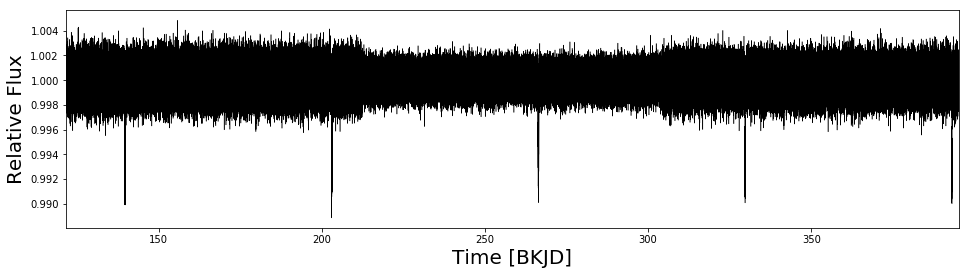

In [10]:
# SHORT CADENCE
# create masks where any planet transits
for i, scq in enumerate(sc_data):
    scq.transit_mask = np.zeros_like(scq.time, dtype='bool')
    
    for npl in range(NPL):
        scq.transit_mask += detrend.make_transitmask(scq.time, planets[npl].tts, planets[npl].duration)
     
    
# determine smoothing kernel based on shortest transit duration
kernel_size = int(DURS.min()/(SCIT/3600/24))
kernel_size += kernel_size % 2 + 1


# do some basic detrending
for i, scq in enumerate(sc_data):
    scq = detrend.detrend_single_quarter(scq, window_length=3001, break_tolerance=750, polyorder=2, \
                                         kernel_size=kernel_size, sigma_upper=5.0, sigma_lower=10.0)
    sc_data[i] = scq
    
    
# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, scq in enumerate(sc_data):
    scq.quarter = scq.quarter*np.ones(len(scq.time))
    scq.channel = scq.channel*np.ones(len(scq.time))
    

try:
    # combine into a single LightCurve
    sc = detrend.stitch_lkc(sc_data)

    # determine seasons
    sc.season = sc.quarter % 4

    plt.figure(figsize=(16,4))
    plt.plot(sc.time, sc.flux, c='k', lw=0.5)
    plt.xlim(sc.time.min(), sc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_short_cadence_flux.pdf', bbox_inches='tight')
    plt.show()
    
except:
    sc = None

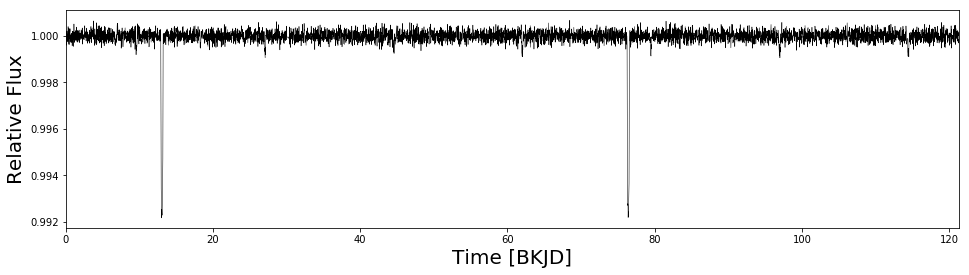

In [11]:
# LONG CADENCE
# create masks where any planet transits
for i, lcq in enumerate(lc_data):
    lcq.transit_mask = np.zeros_like(lcq.time, dtype='bool')
    
    for npl in range(NPL):
        lcq.transit_mask += detrend.make_transitmask(lcq.time, planets[npl].tts, planets[npl].duration)
        
        
# determine smoothing kernel based on shortest transit duration
kernel_size = int(DURS.min()/(LCIT/60/24))
kernel_size += kernel_size % 2 + 1

# do some basic detrending
for i, lcq in enumerate(lc_data):
    lcq = detrend.detrend_single_quarter(lcq, window_length=101, break_tolerance=25, polyorder=2, \
                                         kernel_size=kernel_size, sigma_upper=5.0, sigma_lower=10.0)
    
    lc_data[i] = lcq
    
    
# broadcast quarter and channel integers into arrays (for convenient use after stitching)
for i, lcq in enumerate(lc_data):
    lcq.quarter = lcq.quarter*np.ones(len(lcq.time))
    lcq.channel = lcq.channel*np.ones(len(lcq.time))
    

try:
    # combine into a single LightCurve
    lc = detrend.stitch_lkc(lc_data)

    # determine seasons
    lc.season = lc.quarter % 4
    
    plt.figure(figsize=(16,4))
    plt.plot(lc.time, lc.flux, c='k', lw=0.5)
    plt.xlim(lc.time.min(), lc.time.max())
    plt.xlabel('Time [BKJD]', fontsize=20)
    plt.ylabel('Relative Flux', fontsize=20)
    plt.savefig(FIGURE_DIR + TARGET + '_long_cadence_flux.pdf', bbox_inches='tight')
    plt.show()

except:
    lc = None

# Make individual mask for where each planet transits

In [12]:
print('Making transit masks')
try:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        sc_mask[npl] = detrend.make_transitmask(sc.time, p.tts, p.duration, masksize=1.5)

    sc.mask = sc_mask

except:
    sc_mask = None

    
try:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, p.duration, masksize=1.5)
    
    lc.mask = lc_mask

except:
    lc_mask = None

Making transit masks


# Flag where there is data near transit (quality = 1)

In [13]:
for npl, p in enumerate(planets):

    quality = []

    # cut out the stamps
    for i, t0 in enumerate(p.tts):
        neartransit = np.abs(sc.time - t0)/p.duration < 1.5
        quality.append(np.sum(neartransit) > 0)
        
    p.quality = quality

# Generate and model empirical autocorrelation function (ACF)

Generating autocorrelation function



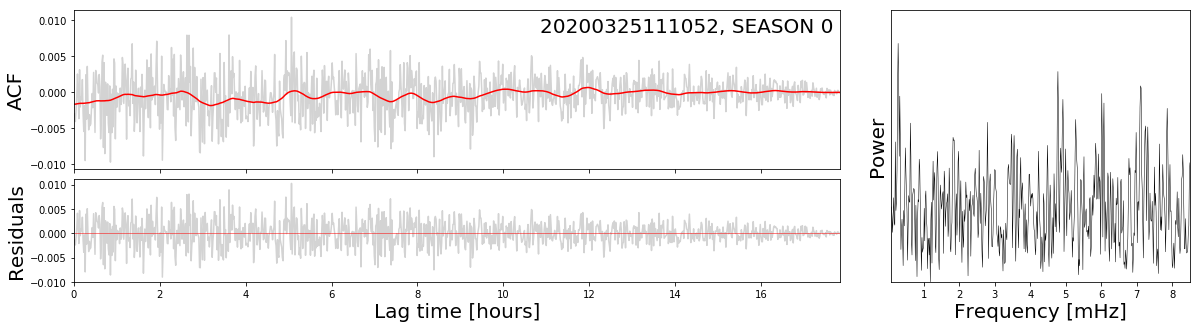

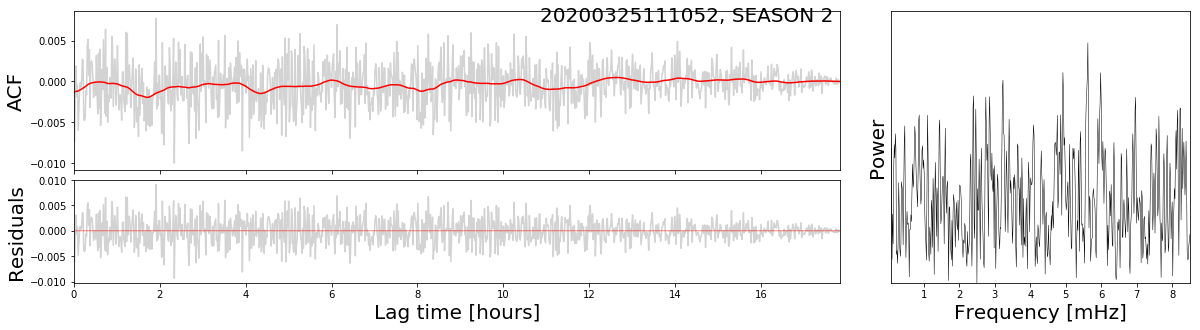

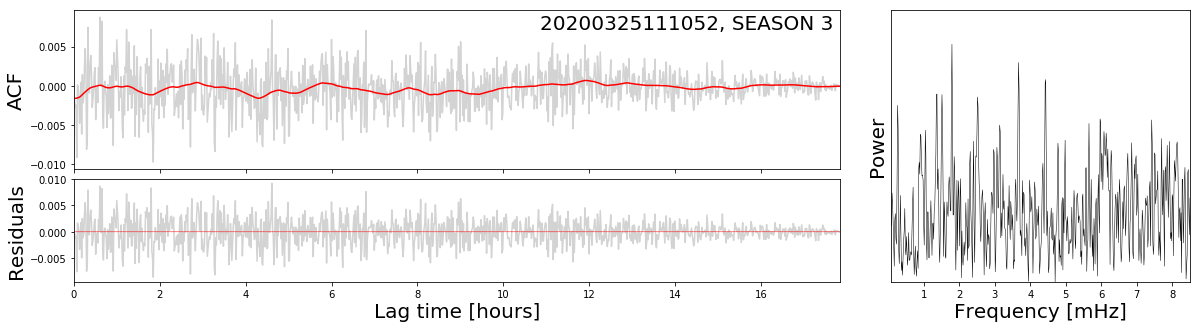

In [16]:
print('Generating autocorrelation function\n')

# set Npts from 3 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(3*durations.max()*24*3600/SCIT)


# set cutoff between low and high frequency signals
fcut = 1/(LCIT/60/24)

# now estimate the ACF
acf_lag = []
acf_emp = []
acf_mod = []
acf_freqs = []


for season in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == season
    scm = scm[use]
    
    if np.sum(use) > 0:
        sc_time = sc.time[use][~scm]
        sc_flux = sc.flux[use][~scm]
        sc_error = sc.error[use][~scm]
        sc_cadno = sc.cadno[use][~scm]

        # generate the empirical acf
        xcor, acor, wcor, acf_stats = noise.generate_acf(sc_time, sc_flux, sc_cadno, Npts)

        # model the acf
        acor_emp, acor_mod, xf, yf, freqs = noise.model_acf(xcor, acor, fcut)

        # add to list
        acf_lag.append(xcor)
        acf_emp.append(acor_emp)
        acf_mod.append(acor_mod)
        acf_freqs.append(freqs)

        # make some plots
        fig = noise.plot_acf(xcor, acor_emp, acor_mod, xf, yf, freqs, TARGET, season)

        fig.savefig(FIGURE_DIR + TARGET + '_ACF_season_{0}.pdf'.format(season), bbox_inches='tight')
        
    else:
        acf_lag.append(None)
        acf_emp.append(None)
        acf_mod.append(None)
        acf_freqs.append(None)

# Generate synthetic noise

Generating synthetic noise



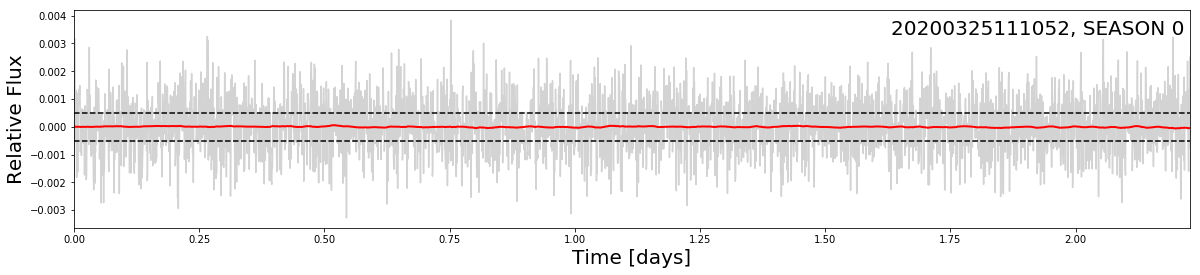

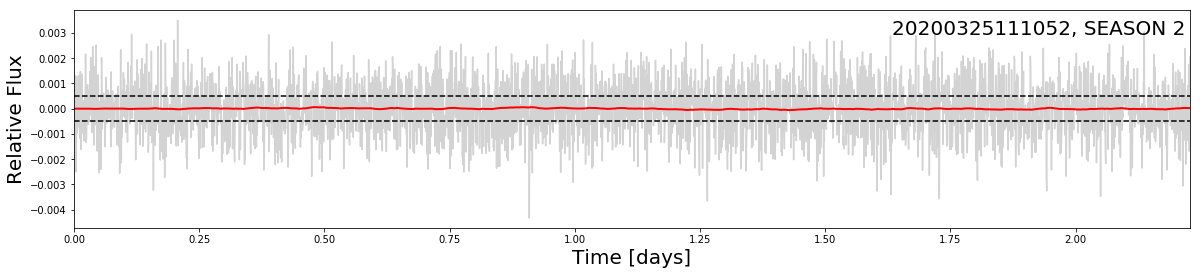

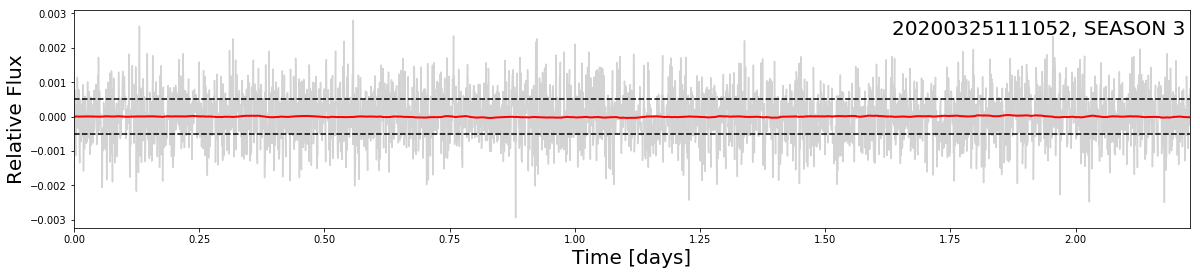

In [17]:
print('Generating synthetic noise\n')

synth_time  = []
synth_red   = []
synth_white = []

for season in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == season
    scm = scm[use]
    
    if np.sum(use) > 0:
        sc_time = sc.time[use][~scm]
        sc_flux = sc.flux[use][~scm]
        sc_error = sc.error[use][~scm]
        sc_cadno = sc.cadno[use][~scm]

        # pull and split high/low frequencies
        freqs = acf_freqs[season]

        low_freqs  = freqs[freqs <= fcut]
        high_freqs = freqs[freqs > fcut]

        # generate some synthetic correlated noise
        n = 3*len(acf_lag[season])
        sigma = np.median(sc_error)

        x, red_noise, white_noise = noise.generate_synthetic_noise(acf_lag[season], acf_emp[season], acf_mod[season], \
                                                                   high_freqs, fcut, n, sigma)

        # add to list
        synth_time.append(x)
        synth_red.append(red_noise)
        synth_white.append(white_noise)

        # plot the noise
        plt.figure(figsize=(20,4))
        plt.plot(x, white_noise + red_noise, c='lightgrey')
        plt.plot(x, red_noise, c='red', lw=2)
        plt.axhline(0.0005, c='k', ls='--')
        plt.axhline(-0.0005, c='k', ls='--')
        plt.xlim(x.min(),x.max())
        plt.xlabel('Time [days]', fontsize=20)
        plt.ylabel('Relative Flux', fontsize=20)
        plt.text(x.max()-0.01, white_noise.max(), '%s, SEASON %d' %(TARGET, season), va='top', ha='right', fontsize=20)
        plt.savefig(FIGURE_DIR + TARGET + '_synthetic_noise_season_{0}.pdf'.format(season), bbox_inches='tight')
        plt.show()
        
    else:
        synth_time.append(None)
        synth_red.append(None)
        synth_white.append(None)

# Fit a GP to the synthetic noise

Fitting a GP to synthetic noise



optimizing logp for variables: [logSw4_x]
90it [00:00, 175.25it/s, logp=3.555857e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 24903.3734795842 -> 35558.5661718548
optimizing logp for variables: [logw0_x]
14it [00:00, 47.82it/s, logp=3.565501e+04] 
message: Optimization terminated successfully.
logp: 35558.5661718548 -> 35655.01253156398
optimizing logp for variables: [logw0_x, logSw4_x]
70it [00:01, 59.61it/s, logp=3.565992e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 35655.01253156398 -> 35659.92407107491
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logw0_x, logSw4_x]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:12<00:00, 231.20draws/s]


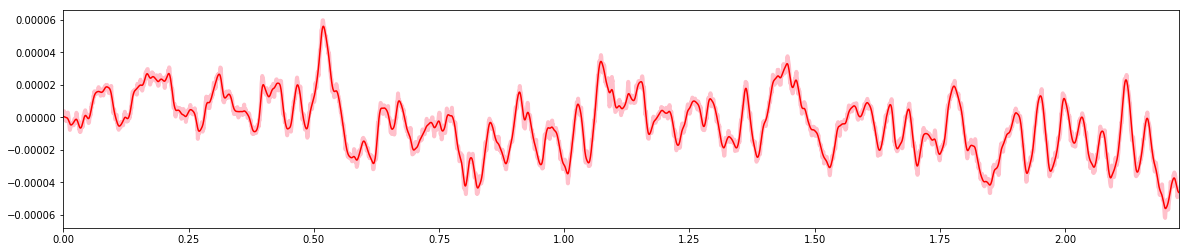

optimizing logp for variables: [logSw4_x]
53it [00:00, 145.51it/s, logp=3.612545e+04]
message: Optimization terminated successfully.
logp: 19107.788660045248 -> 36125.454857909746
optimizing logp for variables: [logw0_x]
14it [00:00, 51.04it/s, logp=3.620908e+04] 
message: Optimization terminated successfully.
logp: 36125.454857909746 -> 36209.07712853046
optimizing logp for variables: [logw0_x, logSw4_x]
110it [00:01, 72.28it/s, logp=3.621275e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 36209.07712853046 -> 36212.74729908229
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logw0_x, logSw4_x]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:13<00:00, 223.64draws/s]


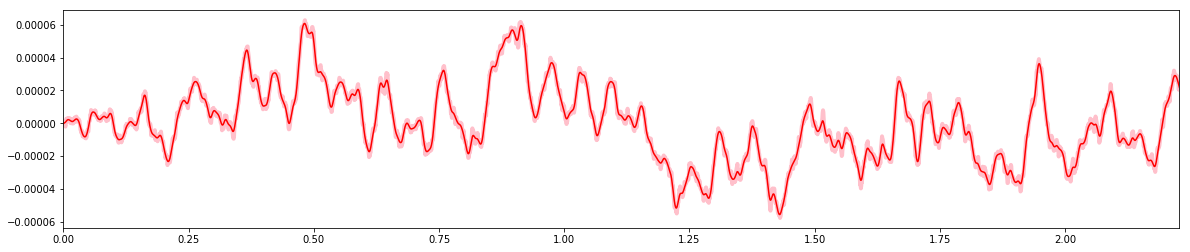

optimizing logp for variables: [logSw4_x]
50it [00:00, 124.25it/s, logp=3.680541e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: 24183.185068943407 -> 36805.40793680188
optimizing logp for variables: [logw0_x]
14it [00:00, 49.24it/s, logp=3.689613e+04] 
message: Optimization terminated successfully.
logp: 36805.40793680188 -> 36896.132692138446
optimizing logp for variables: [logw0_x, logSw4_x]
89it [00:00, 175.45it/s, logp=3.690017e+04]
message: Optimization terminated successfully.
logp: 36896.132692138446 -> 36900.17471189063
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logw0_x, logSw4_x]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 251.68draws/s]


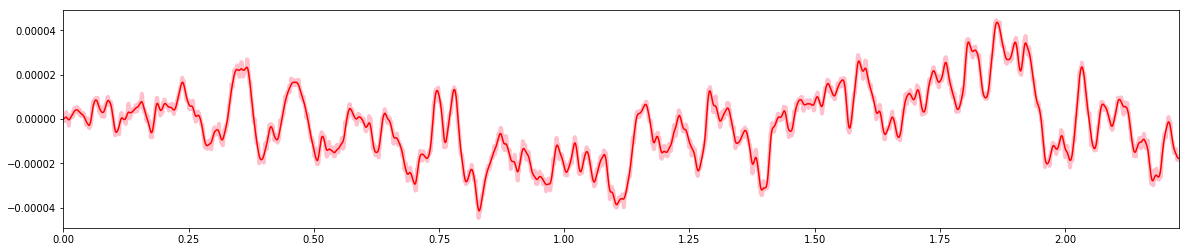

In [25]:
print('Fitting a GP to synthetic noise\n')

gp_model  = []
gp_trace  = []
gp_priors = []

for i in range(4):
    # make a mask where any planet transits
    scm = sc.mask.sum(axis=0) > 0
    
    # pull out a particular season
    use = sc.season == i
    scm = scm[use]
    
    if np.sum(use) > 0:
        sc_time = sc.time[use][~scm]
        sc_flux = sc.flux[use][~scm]
        sc_error = sc.error[use][~scm]
        sc_cadno = sc.cadno[use][~scm]

        # pull and split high/low frequencies
        freqs = acf_freqs[i]

        low_freqs  = freqs[freqs <= fcut]
        high_freqs = freqs[freqs > fcut]


        # fit a GP model to the synthetic noise
        if len(low_freqs) > 0:
            lf = [low_freqs[0]]
            extra_term = None
        else:
            lf = None
            extra_term = 'fixed'


        if len(high_freqs) > 0:
            if len(high_freqs) == 1:
                hf = high_freqs
            else: hf = high_freqs[[0,1]]
        else:
            hf = None


        gp_model.append(noise.build_sho_model(synth_time[i], synth_red[i], var_method='local', \
                                              low_freqs=lf, high_freqs=hf, extra_term=extra_term, match_Q=True))
        
    else:
        gp_model.append(None)
        
        
    if np.sum(use) > 0:
        with gp_model[i] as model:
            map_soln = exo.optimize(start=model.test_point, vars=[model.vars[0]])

            for mv in model.vars[1:]:
                map_soln = exo.optimize(start=map_soln, vars=[mv])

            map_soln = exo.optimize(start=map_soln)


        with gp_model[i] as model:
            trace = pm.sample(tune=1000, draws=500, start=map_soln, chains=2, \
                              step=exo.get_dense_nuts_step(target_accept=0.9))

        plt.figure(figsize=(20,4))
        plt.plot(synth_time[i], synth_red[i], c='pink', lw=4)
        plt.plot(synth_time[i], np.median(trace['gp_pred'], axis=0), c='red')
        plt.xlim(synth_time[i].min(), synth_time[i].max())
        plt.savefig(FIGURE_DIR + TARGET + '_GP_noise_model_{0}.pdf'.format(i), bbox_inches='tight')
        plt.show()

        # transfer trace posteriors to new prior dictionary
        if lf is None: lf = []
        if hf is None: hf = []

        gp_trace.append(trace)
        gp_priors.append(noise.make_prior_dict(trace, lf, hf))
        
        
    else:        
        # these are dummy values that effectively create a zero-amplitude kernel
        gpi = {}
        gpi['logw0'] = 4.
        gpi['logSw4'] = -15.
        gpi['logQ'] = np.log(1/np.sqrt(2))
        gp_priors.append(gpi)
        
        
# save the GP trace results
gp_var_names=['logw0', 'logSw4', 'logQ', 'logw0_x', 'logSw4_x', 'logQ_x', 'logS1', 'logS2', 'logQ1']

for i, gpt in enumerate(gp_trace):
    if gpt is not None:
        varnames = np.array(gpt.varnames)[np.isin(gpt.varnames, gp_var_names)]    

        hdulist = io.trace_to_hdulist(gpt, varnames, TARGET)
        hdulist.writeto(TRACE_DIR + TARGET + '_gp_{0}.fits'.format(i), overwrite=True)

# Grab the relevant data and starting transit parameters

In [22]:
# use only flux near transits (short cadence)
scm = sc.mask.sum(axis=0) > 0

sc_time = []
sc_flux = []
sc_error = []
sc_cadno = []

# separate the seasons
for season in range(4):
    use = sc.season[scm] == season

    sc_time.append(sc.time[scm][use])
    sc_flux.append(sc.flux[scm][use])
    sc_error.append(sc.error[scm][use])
    sc_cadno.append(sc.cadno[scm][use])

    
# use only flux near transits (long cadence)
lcm = lc.mask.sum(axis=0) > 0

lc_time = []
lc_flux = []
lc_error = []
lc_cadno = []

# separate the seasons
for season in range(4):
    use = lc.season[lcm] == season

    lc_time.append(lc.time[lcm][use])
    lc_flux.append(lc.flux[lcm][use])
    lc_error.append(lc.error[lcm][use])
    lc_cadno.append(lc.cadno[lcm][use])
    
    
# pull basic transit parameters
epochs  = np.zeros(NPL)
periods = np.zeros(NPL)
depths  = np.zeros(NPL)
durs    = np.zeros(NPL)
impacts = np.zeros(NPL)

for npl, p in enumerate(planets):
    epochs[npl]  = p.epoch
    periods[npl] = p.period
    depths[npl]  = p.depth
    durs[npl]    = p.duration
    impacts[npl] = p.impact
    
radii = np.sqrt(depths)*RSTAR

# (1) Fit a transit model with polynomial TTVs

The TTV model is built as perturbations from a fixed Keplerian ephemeris. This ephemeris ("kep_ephemeris") is first caluated from the linear least squares fit epoch and period and is NOT varied during model fitting. Long-term, secular TTVs are parameterized as 3rd order Legendre polynomials as functions of dimensionless variable ("x") in the range (-1,1)

In [ ]:
print('\n(1) Fitting POLYNOMIAL TTV model')

In [ ]:
# pull transit_inds (zero indexed) and calculate initial Keplerian ephemeris
transit_inds  = []
KEP_EPHEMERIS = []

for npl, p in enumerate(planets):
    transit_inds.append((p.index - p.index.min())[p.quality])
    KEP_EPHEMERIS.append((p.epoch + p.index*p.period)[p.quality])
    
    transit_inds[npl] -= transit_inds[npl].min()
    
# use Legendre polynomials for better orthogonality; "x" is in the range (-1,1)
Leg0 = []
Leg1 = []
Leg2 = []
Leg3 = []
t = []

# this assumes a baseline in the range (0,TIME_END)
for npl, p in enumerate(planets):    
    t.append(KEP_EPHEMERIS[npl])
    x = (2*t[npl]-TIME_END)/TIME_END

    Leg0.append(np.ones_like(x))
    Leg1.append(x.copy())
    Leg2.append(0.5*(3*x**2 - 1))
    Leg3.append(0.5*(5*x**3 - 3*x))

In [ ]:
with pm.Model() as poly_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # polynomial TTV parameters
    C0 = pm.Normal('C0', mu=0.0, sd=1e-4, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=1e-4, shape=NPL)
    C2 = pm.Normal('C2', mu=0.0, sd=1e-4, shape=NPL)
    C3 = pm.Normal('C3', mu=0.0, sd=1e-4, shape=NPL)

    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              KEP_EPHEMERIS[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl]))
    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])
        
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]

        
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [ ]:
with poly_model:
    poly_map = exo.optimize(start=poly_model.test_point, vars=[logvar])
    poly_map = exo.optimize(start=poly_map, vars=[flux0])
    poly_map = exo.optimize(start=poly_map, vars=[b])
    poly_map = exo.optimize(start=poly_map, vars=[u, Mstar])
    poly_map = exo.optimize(start=poly_map, vars=[C0, C1, C2, C3])
    poly_map = exo.optimize(start=poly_map)

In [ ]:
# grab the model flux and gp prediction
model_flux = []
gp_pred = []

for i in range(4):
    model_flux.append(poly_map['model_flux_{0}'.format(i)])
    gp_pred.append(poly_map['gp_pred_{0}'.format(i)])


# plot the model lightcurve
plt.figure(figsize=(20,4))
for i in range(4):
    plt.plot(sc_time[i], sc_flux[i], '.', color='lightgrey')
    plt.plot(sc_time[i], model_flux[i] + gp_pred[i])
plt.show()


# grab transit times and ephemeris
poly_transit_times = []
poly_ephemeris = []

for npl, p in enumerate(planets):
    poly_transit_times.append(poly_map['tts_{0}'.format(npl)])
    poly_ephemeris.append(poly_map['P'][npl]*transit_inds[npl] + poly_map['T0'][npl])

    
# plot the OMC TTVs
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = poly_transit_times[npl]
    yomc  = (poly_transit_times[npl] - poly_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_poly.pdf', bbox_inches='tight')
plt.show()

# (2) Fit independent TTVs

In [ ]:
print('\n(2) Fitting INDEPENDENT TTV model')

In [ ]:
radii   = poly_map['rp']
impacts = poly_map['b']

Rstar = poly_map['Rstar']
Mstar = poly_map['Mstar']
u = poly_map['u']

In [ ]:
with pm.Model() as indep_model:
    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
        
    
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1.0, shape=len(poly_ephemeris[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              poly_ephemeris[npl] + tt_offset[npl]*durations[npl]/3))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=impacts, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=radii, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])
    
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]        
            
            
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [ ]:
with indep_model:
    indep_map = exo.optimize(start=indep_model.test_point)

In [ ]:
indep_transit_times = []
indep_ephemeris = []

for npl in range(NPL):
    indep_transit_times.append(indep_map['tts_{0}'.format(npl)])
    indep_ephemeris.append(indep_map['P'][npl]*transit_inds[npl] + indep_map['T0'][npl])
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = indep_transit_times[npl]
    yomc  = (indep_transit_times[npl] - indep_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_indep.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# here are the limits of the sinusoidal frequencies
fttv_min = (3/2)/TIME_END*np.ones(NPL)
fttv_max = 1/(4*periods)

# Search the TTVs for significant frequencies
fttv1_ls = np.zeros(NPL)
fttv2_ls = np.zeros(NPL)
ttv_amps = np.zeros(NPL)

for npl, p in enumerate(planets):
    lombscargle = ttv_lombscargle_analysis(indep_transit_times[npl], indep_ephemeris[npl], indep_map['P'][npl])
    
    fttv1_ls[npl] = lombscargle['peak_freq']
    
    if lombscargle['peak_fap'] > 0.01:
        fttv2_ls[npl] = lombscargle['2nd_peak']
        
    else:
        if 2*fttv1_ls[npl] < fttv_max[npl]:
            fttv2_ls[npl] = 2*fttv1_ls[npl]
        elif 0.5*fttv1_ls[npl] > fttv_min[npl]:
            fttv2_ls[npl] = 0.5*fttv1_ls[npl]
        else:
            fttv2_ls[npl] = lombscargle['2nd_peak']
    
    ttv_amps[npl]  = astropy.stats.mad_std(indep_transit_times[npl] - indep_ephemeris[npl])
    
    
    plt.figure()
    plt.plot(lombscargle['freq'], lombscargle['power'], c='grey')
    plt.axvline(fttv1_ls[npl], c='C{0}'.format(npl))
    plt.axvline(fttv2_ls[npl], c='C{0}'.format(npl), ls=':')
    plt.text(lombscargle['freq'].min(), lombscargle['power'].max(), \
             'FAP = ' + str(lombscargle['peak_fap'].round(3)), \
             va='top', ha='left', fontsize=12)
    plt.xlabel('frequency', fontsize=16)
    plt.ylabel('power', fontsize=16)
    plt.show()

# (3) Fit a transit model with both polynomial and sinusoidal components

In [ ]:
print('\n(3) Fitting SINUSOIDAL TTV model')

In [ ]:
with pm.Model() as sin_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(radii), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=impacts, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # polynomial TTV parameters
    C0 = pm.Normal('C0', mu=0.0, sd=1e-4, shape=NPL)
    C1 = pm.Normal('C1', mu=0.0, sd=1e-4, shape=NPL)
    C2 = pm.Normal('C2', mu=0.0, sd=1e-4, shape=NPL)
    C3 = pm.Normal('C3', mu=0.0, sd=1e-4, shape=NPL)
    
    
    # sinusoidal TTV parameters
    fplus  = pm.Uniform('fplus', lower=2*fttv_min, upper=2*fttv_max, testval=fttv1_ls+fttv2_ls, shape=NPL)
    fminus = pm.Uniform('fminus', lower=fttv_min-fttv_max, upper=fttv_max-fttv_min, testval=fttv1_ls-fttv2_ls, shape=NPL)
    
    fttv1 = pm.Deterministic('fttv2', 0.5*(fplus+fminus))
    fttv2 = pm.Deterministic('fttv1', 0.5*(fplus-fminus))
        
    A1 = pm.Normal('A1', mu=0, sd=1, shape=NPL)
    B1 = pm.Normal('B1', mu=0, sd=1, shape=NPL)
    A2 = pm.Normal('A2', mu=0, sd=1, shape=NPL)
    B2 = pm.Normal('B2', mu=0, sd=1, shape=NPL)
    
    Amp = pm.HalfCauchy('Amp', beta=np.std(ttv_amps)/4, shape=NPL)
    
    
    # transit times
    transit_times = []
    for npl in range(NPL):
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              indep_ephemeris[npl] + \
                                              C0[npl]*Leg0[npl] + C1[npl]*Leg1[npl] + \
                                              C2[npl]*Leg2[npl] + C3[npl]*Leg3[npl] + \
                                              Amp[npl]*A1[npl]*T.sin(2*pi*fttv1[npl]*t[npl]) + \
                                              Amp[npl]*B1[npl]*T.cos(2*pi*fttv1[npl]*t[npl]) + \
                                              Amp[npl]*A2[npl]*T.sin(2*pi*fttv2[npl]*t[npl]) + \
                                              Amp[npl]*B2[npl]*T.cos(2*pi*fttv2[npl]*t[npl])))
                

    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])
 
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]       
            
            
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [ ]:
with sin_model:
    sin_map = exo.optimize(start=sin_model.test_point, vars=[logvar])
    sin_map = exo.optimize(start=sin_map, vars=[flux0])
    sin_map = exo.optimize(start=sin_map, vars=[C0, C1, C2, C3])
    sin_map = exo.optimize(start=sin_map, vars=[A1, B1, A2, B2, Amp, fplus, fminus])
    sin_map = exo.optimize(start=sin_map, vars=[b])
    sin_map = exo.optimize(start=sin_map, vars=[u, Mstar])
    sin_map = exo.optimize(start=sin_map)

In [ ]:
sin_transit_times = []
sin_ephemeris = []
beta = []

for npl, p in enumerate(planets):
    sin_transit_times.append(sin_map['tts_{0}'.format(npl)])
    sin_ephemeris.append(sin_map['P'][npl]*transit_inds[npl] + sin_map['T0'][npl])
    beta.append(p.duration)
    
    
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = sin_transit_times[npl]
    yomc  = (sin_transit_times[npl] - sin_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_sin.pdf', bbox_inches='tight')
plt.show()

# (4) Finally, fit hierarchical TTVs

In [ ]:
print('\n(4) Fitting HIERARCHICAL TTV model')

In [ ]:
radii   = sin_map['rp']
impacts = sin_map['b']

Rstar = sin_map['Rstar']
Mstar = sin_map['Mstar']
u = sin_map['u']

In [ ]:
beta = np.zeros(NPL)

for npl, p in enumerate(planets):
    beta[npl] = np.std(indep_transit_times[npl] - indep_ephemeris[npl])/4

In [ ]:
with pm.Model() as hbm_model:
    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)
    logvar = pm.Normal('logvar', mu=np.log(np.var(np.hstack(sc_flux))), sd=10.0)
    
    
    # hierarchical population parameters
    pop_sd = pm.HalfCauchy('pop_sd', beta=beta, shape=NPL)
    
    
    # transit times
    tt_offset = []
    transit_times = []
    for npl in range(NPL):
        tt_offset.append(pm.Normal('tt_offset_{0}'.format(npl), mu=0, sd=1.0, shape=len(sin_transit_times[npl])))
        
        transit_times.append(pm.Deterministic('tts_{0}'.format(npl), \
                                              sin_transit_times[npl] + tt_offset[npl]*pop_sd[npl]))
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=transit_inds, \
                                 b=impacts, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # use a different noise model for each season
    light_curves       = [None]*4
    summed_light_curve = [None]*4
    model_flux         = [None]*4
    
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    
    kernel  = [None]*4
    gp      = [None]*4
    gp_pred = [None]*4
    
    for i in range(4):
        light_curves[i] = exoSLC.get_light_curve(orbit=orbit, r=radii, t=sc_time[i])
        summed_light_curve[i] = pm.math.sum(light_curves[i], axis=-1) + flux0*T.ones(len(sc_time[i]))
        model_flux[i] = pm.Deterministic('model_flux_{0}'.format(i), summed_light_curve[i])

        #logSw4[i] = gp_priors[i]['logSw4'][0]
        #logw0[i]  = gp_priors[i]['logw0'][0]
        #logQ[i]   = gp_priors[i]['logQ'][0]
    
        gpi = gp_priors[i]
        
        try:
            logSw4[i] = pm.Normal('logSw4_{0}'.format(i), mu=gpi['logSw4'][0], sd=gpi['logSw4'][1])
        except:
            logSw4[i] = gpi['logSw4'][0]
            
        try:
            logw0[i] = pm.Normal('logw0_{0}'.format(i), mu=gpi['logw0'][0], sd=gpi['logw0'][1])
        except:
            logw0[i] = gpi['logw0'][0]

        try:
            logQ[i] = pm.Normal('logQ_{0}'.format(i), mu=gpi['logQ'][0], sd=gpi['logQ'][1])
        except:
            logQ[i] = gpi['logQ'][0]       

            
        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
        gp[i] = exo.gp.GP(kernel[i], sc_time[i], T.exp(logvar)*T.ones(len(sc_time[i])))

    
        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(i), gp[i].log_likelihood(sc_flux[i] - model_flux[i]))

    
        # track GP prediction
        gp_pred[i] = pm.Deterministic('gp_pred_{0}'.format(i), gp[i].predict())

In [ ]:
with hbm_model:
    hbm_map = exo.optimize(start=hbm_model.test_point)

In [ ]:
hbm_transit_times = []
hbm_ephemeris = []
hbm_err = []

for npl in range(NPL):
    hbm_transit_times.append(hbm_map['tts_{0}'.format(npl)])
    hbm_ephemeris.append(hbm_map['P'][npl]*transit_inds[npl] + hbm_map['T0'][npl])
    
    hbm_err.append(np.ones_like(hbm_ephemeris[npl])*np.std(hbm_transit_times[npl]-sin_transit_times[npl]))

In [ ]:
fig, axes = plt.subplots(NPL, figsize=(12,8))

for npl, p in enumerate(planets):
    xtime = hbm_transit_times[npl]
    yomc  = (hbm_transit_times[npl] - hbm_ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.savefig(FIGURE_DIR + TARGET + '_ttvs_hbm.pdf', bbox_inches='tight')
plt.show()

# Sample from posteriors for HBM transit times

In [ ]:
with hbm_model:
    hbm_trace = pm.sample(tune=3000, draws=1000, start=hbm_map, chains=2, \
                      step=exo.get_dense_nuts_step(target_accept=0.9))

In [ ]:
hbm_varnames = ['pop_sd']

for npl in range(NPL):
    hbm_varnames.append('tts_{0}'.format(npl))


hbm_hdulist = io.trace_to_hdulist(hbm_trace, hbm_varnames, TARGET)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

In [ ]:
print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

In [ ]:
new_ttv_freqs = np.zeros(NPL)

for npl, p in enumerate(planets):
    new_ttv_freqs[npl] = find_ttv_frequencies(hbm_transit_times[npl], hbm_ephemeris[npl], hbm_map['P'][npl])

In [ ]:
for npl in range(NPL):
    np.save('/Users/research/Desktop/K00137_hbm_tts_{0}'.format(npl), hbm_transit_times[npl])
    np.save('/Users/research/Desktop/K00137_hbm_err_{0}'.format(npl), hbm_err[npl])